$\LARGE{MDS7201}$

Interpretabilidad

Bibliografía:
[Interpretable machine learning, A Guide for Making Black Box Models Explainable, Christoph Molnar](https://christophm.github.io/interpretable-ml-book/)



# Interpretabilidad

Un aspecto importante y muchas veces ignorado de ML es la interpretabilidad.

Podemos entender cómo decide un modelo de clasificación o regresión para una muestra dada? Esto está de acuerdo con nuestra intuición?

Es importante que un modelo sea capaz de explicar sus decisiones para comprobar lo siguiente:
    
- sesgos: están las predicciones sesgadas?
- privacidad: se protegen los datos sensibles?
- robustez: pequeños cambios en la entrada producen grandes cambios en la predicción?
- debugging: entender la contribución de características puede ayudar a detectar fallas en el modelo, como sobre ajustes o la presencia de características irrelevantes.
- causalidad: se recuperan sólo las relaciones causales?
- confiabilidad: puedo confiar en el sistema? Normalmente para confiar en algo se debe entender su funcionamiento.

# Clases de interpretabilidad

Los métodos de interpretabilidad pueden ser clasificados como intrínsecos o post hoc:

Los métodos intrínsecos se refieren a modelos que son simples de entender, e.g. un árbol de decisión o una regresión lineal.

Los métodos post hoc se refieren a métodos aplicados después del entrenamiento.

Mientras algunos modelos son intrínsecamente interpretables, como los árboles de decisión, otros modelos requieren métodos de interpretabilidad agnósticos al modelo.

Adicionalmente, los métodos de interpretabilidad pueden ser clasificados de acuerdo a sus resultados: 

* estadístico resumen de características: muchos métodos de interpretabilidad retornan estadísticos resumen por característica.

* visualización resumen de características: a veces, en lugar de una estadístico, es más útil visualizar la distribución de propiedades asociadas a una o más características de la muestra completa.

* propiedades internas del modelo: a veces, el modelo contiene parámetros que son directamente interpretables, e.g., los coeficientes de un modelo lineal

* una muestra: algunos métodos retornan muestras (nuevas o existentes) para hacer el modelo interpretables. Por ejemplo, explicaciones contrafactuales: identificar un cambio que habría provocado un gran cambio en la predicción; o encontrar un prototipo de una clase dada.

* modelos intrínsecamente interpretables: en algunos casos los modelos son fáciles de interpretar y no requiere de métodos especiales, e.g. un árbol de decisión.

Si tengo un modelo de clasificación de estrellas pulsantes, cuál es la contribución del período y la amplitud de las variaciones en la clasificación?

![](images/pulsating_stars.png)

# Métodos agnósticos al modelo

No siempre es posible construir modelos interpretables con el mismo poder predictivo de los modelos no interpretables.

Algunos aspectos desesables de un bueno modelo interpretables son los siguientes:

- Flexibilidad del modelo: el método funciona con cualquier tipo de modelo, e.g. random forest o redes neuronales profundas
- Flexibilidad de explicabilidad: el método no está limitado a un tipo de explicación, e.g. un estadístico resumen o visualización.
- Flexibilidad de representación: la explicación debería ser capaz de usar distintos tipos de representaciones de la entrada, e.g. palabras vs embeddings, regiones vs pixeles.

Un método de interpretabilidad puede ser local, i.e. explica la predicción de una muestra, o global, i.e. explica la distribución de la muestra completa.

## Métodos globalmente agnósticos

Entre los métodos globalmente agnósticos, tal vez el mejor conocido es el partial dependence plot (PDP or PD).

PDP muestra el efecto marginal que una o más características tienen sobre la predicción.

La función de dependencia parcial se define como:


$\Large \hat f_S(x_S) = E_{X_C} [\hat f(x_S, X_C)] = \int \hat f(x_S, X_C) dP(X_C)$

donde $x_S$ son las características para las cuáles queremos conocer la función de dependencia parcial y $X_C$ son las demás características. Esto significa que la salida del modelo está marginalizada sobre la distribución de las características $X_C$.

### Set de datos de esquemas de bicicletas compartidas

Ver https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html

In [11]:
from sklearn.datasets import fetch_openml

bikes = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True, parser="pandas")
# Make an explicit copy to avoid "SettingWithCopyWarning" from pandas
X, y = bikes.data.copy(), bikes.target

Matrix de diseño

In [12]:
X

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
0,spring,0,1,0,False,6,False,clear,9.84,14.395,0.81,0.0000
1,spring,0,1,1,False,6,False,clear,9.02,13.635,0.80,0.0000
2,spring,0,1,2,False,6,False,clear,9.02,13.635,0.80,0.0000
3,spring,0,1,3,False,6,False,clear,9.84,14.395,0.75,0.0000
4,spring,0,1,4,False,6,False,clear,9.84,14.395,0.75,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
17374,spring,1,12,19,False,1,True,misty,10.66,12.880,0.60,11.0014
17375,spring,1,12,20,False,1,True,misty,10.66,12.880,0.60,11.0014
17376,spring,1,12,21,False,1,True,clear,10.66,12.880,0.60,11.0014
17377,spring,1,12,22,False,1,True,clear,10.66,13.635,0.56,8.9981


Número de usuarios

In [13]:
y

0         16
1         40
2         32
3         13
4          1
        ... 
17374    119
17375     89
17376     90
17377     61
17378     49
Name: count, Length: 17379, dtype: int64

Distribución de condiciones atmoféricas 

In [14]:
X["weather"].value_counts()

clear         11413
misty          4544
rain           1419
heavy_rain        3
Name: weather, dtype: int64

Reemplacemos lluvia fuerte por lluvia para balancear

In [15]:
X["weather"].replace(to_replace="heavy_rain", value="rain", inplace=True)

Distribución de años

In [17]:
X["year"].value_counts()

1    8734
0    8645
Name: year, dtype: int64

Usaremos el primer año para entrenar y el segundo para testear

In [18]:
mask_training = X["year"] == 0.0
X = X.drop(columns=["year"])
X_train, y_train = X[mask_training], y[mask_training]
X_test, y_test = X[~mask_training], y[~mask_training]

Información de los datos de entrenamiento

In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8645 entries, 0 to 8644
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      8645 non-null   category
 1   month       8645 non-null   int64   
 2   hour        8645 non-null   int64   
 3   holiday     8645 non-null   category
 4   weekday     8645 non-null   int64   
 5   workingday  8645 non-null   category
 6   weather     8645 non-null   category
 7   temp        8645 non-null   float64 
 8   feel_temp   8645 non-null   float64 
 9   humidity    8645 non-null   float64 
 10  windspeed   8645 non-null   float64 
dtypes: category(4), float64(4), int64(3)
memory usage: 574.7 KB


Visualización de usuarios en distintos años, estación y hora del día durante una semana

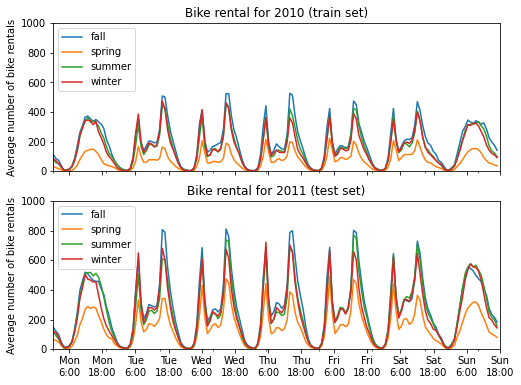

In [21]:
from itertools import product
import numpy as np
import matplotlib.pyplot as plt

days = ("Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun")
hours = tuple(range(24))
xticklabels = [f"{day}\n{hour}:00" for day, hour in product(days, hours)]
xtick_start, xtick_period = 6, 12

fig, axs = plt.subplots(nrows=2, figsize=(8, 6), sharey=True, sharex=True)
average_bike_rentals = bikes.frame.groupby(["year", "season", "weekday", "hour"]).mean(
    numeric_only=True
)["count"]
for ax, (idx, df) in zip(axs, average_bike_rentals.groupby("year")):
    df.groupby("season").plot(ax=ax, legend=True)

    # decorate the plot
    ax.set_xticks(
        np.linspace(
            start=xtick_start,
            stop=len(xticklabels),
            num=len(xticklabels) // xtick_period,
        )
    )
    ax.set_xticklabels(xticklabels[xtick_start::xtick_period])
    ax.set_xlabel("")
    ax.set_ylabel("Average number of bike rentals")
    ax.set_title(
        f"Bike rental for {'2010 (train set)' if idx == 0.0 else '2011 (test set)'}"
    )
    ax.set_ylim(0, 1_000)
    ax.set_xlim(0, len(xticklabels))
    ax.legend(loc=2)

Variables numéricas y categóricas

In [23]:
numerical_features = [
    "temp",
    "feel_temp",
    "humidity",
    "windspeed",
]
categorical_features = X_train.columns.drop(numerical_features)

Preprocesamiento para MLP

In [24]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import OneHotEncoder

mlp_preprocessor = ColumnTransformer(
    transformers=[
        ("num", QuantileTransformer(n_quantiles=100), numerical_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)
mlp_preprocessor

ColumnTransformer(transformers=[('num', QuantileTransformer(n_quantiles=100),
                                 ['temp', 'feel_temp', 'humidity',
                                  'windspeed']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 Index(['season', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weather'],
      dtype='object'))])

Preprocesamiento para gradient boosting regressor

In [25]:
from sklearn.preprocessing import OrdinalEncoder

hgbdt_preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(), categorical_features),
        ("num", "passthrough", numerical_features),
    ],
    sparse_threshold=1,
    verbose_feature_names_out=False,
).set_output(transform="pandas")
hgbdt_preprocessor

ColumnTransformer(sparse_threshold=1,
                  transformers=[('cat', OrdinalEncoder(),
                                 Index(['season', 'month', 'hour', 'holiday', 'weekday', 'workingday',
       'weather'],
      dtype='object')),
                                ('num', 'passthrough',
                                 ['temp', 'feel_temp', 'humidity',
                                  'windspeed'])],
                  verbose_feature_names_out=False)

Entrenamiento de MLP

In [26]:
from time import time
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline

print("Training MLPRegressor...")
tic = time()
mlp_model = make_pipeline(
    mlp_preprocessor,
    MLPRegressor(
        hidden_layer_sizes=(30, 15),
        learning_rate_init=0.01,
        early_stopping=True,
        random_state=0,
    ),
)
mlp_model.fit(X_train, y_train)
print(f"done in {time() - tic:.3f}s")
print(f"Test R2 score: {mlp_model.score(X_test, y_test):.2f}")

Training MLPRegressor...
done in 1.523s
Test R2 score: 0.61


Partial dependency plot para MLP

Computing partial dependence plots...
done in 1.889s


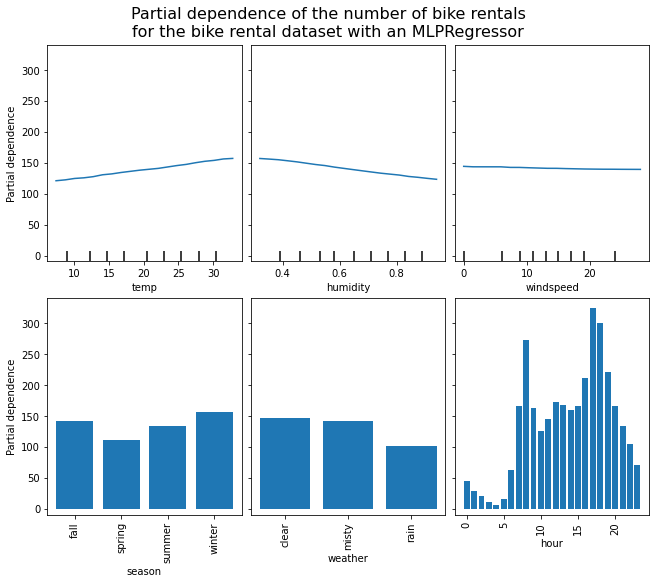

In [27]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

print("Computing partial dependence plots...")
features_info = {
    # features of interest
    "features": ["temp", "humidity", "windspeed", "season", "weather", "hour"],
    # type of partial dependence plot
    "kind": "average",
    # information regarding categorical features
    "categorical_features": categorical_features,
}
tic = time()
_, ax = plt.subplots(ncols=3, nrows=2, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    mlp_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    "Partial dependence of the number of bike rentals\n"
    "for the bike rental dataset with an MLPRegressor",
    fontsize=16,
)

Entrenamiento para Gradient Boosting Regressor

In [28]:
from sklearn.ensemble import HistGradientBoostingRegressor

print("Training HistGradientBoostingRegressor...")
tic = time()
hgbdt_model = make_pipeline(
    hgbdt_preprocessor,
    HistGradientBoostingRegressor(
        categorical_features=categorical_features, random_state=0
    ),
)
hgbdt_model.fit(X_train, y_train)
print(f"done in {time() - tic:.3f}s")
print(f"Test R2 score: {hgbdt_model.score(X_test, y_test):.2f}")

Training HistGradientBoostingRegressor...
done in 0.298s
Test R2 score: 0.64


Partial dependency plot para Gradient Boosting Regressor

Computing partial dependence plots...
done in 2.365s


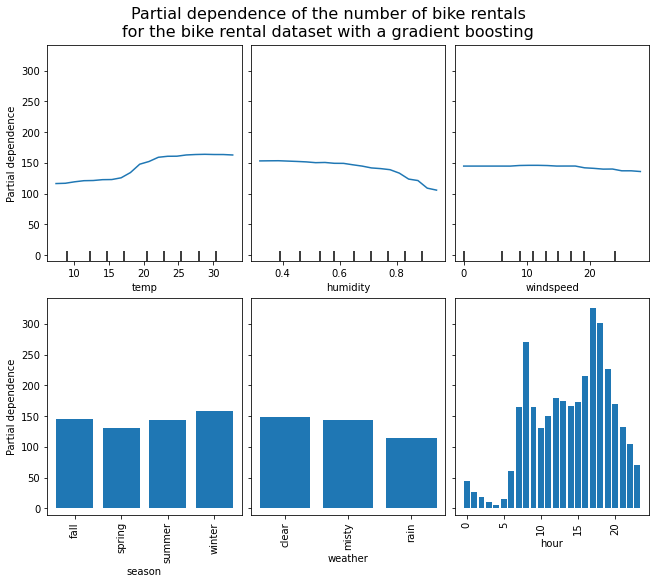

In [29]:
print("Computing partial dependence plots...")
tic = time()
_, ax = plt.subplots(ncols=3, nrows=2, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    "Partial dependence of the number of bike rentals\n"
    "for the bike rental dataset with a gradient boosting",
    fontsize=16,
)

Se observa no linealidad en la dependencia con la temperatura entre 15 y 25 C y en la humedad por encima del 70%.

Partial dependency plot usando dos variables: temperatura y humedad.

Computing partial dependence plots...
done in 11.084s


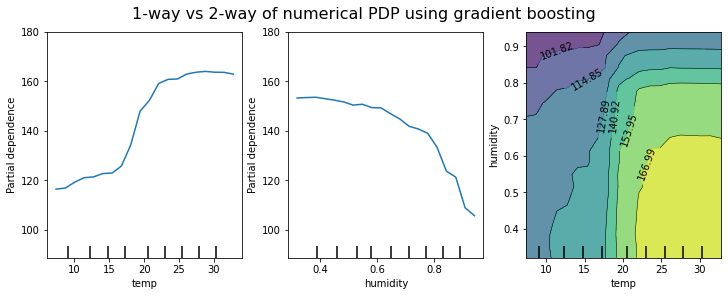

In [30]:
print("Computing partial dependence plots...")
features_info = {
    "features": ["temp", "humidity", ("temp", "humidity")],
    "kind": "average",
}
_, ax = plt.subplots(ncols=3, figsize=(10, 4), constrained_layout=True)
tic = time()
display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    "1-way vs 2-way of numerical PDP using gradient boosting", fontsize=16)

Se observa que a temperaturas mayores a 20 C, el efecto dominante es la humedad. a temperaturas menores a 20 C y humedades menores a 70 % la temperatura parece ser más importante, mientras que a humedades mayores a 70% la humedad siempre parece ser más importante.

Partial dependency plot como función de la estación y condiciones atmosféricas.

Computing partial dependence plots...
done in 0.519s


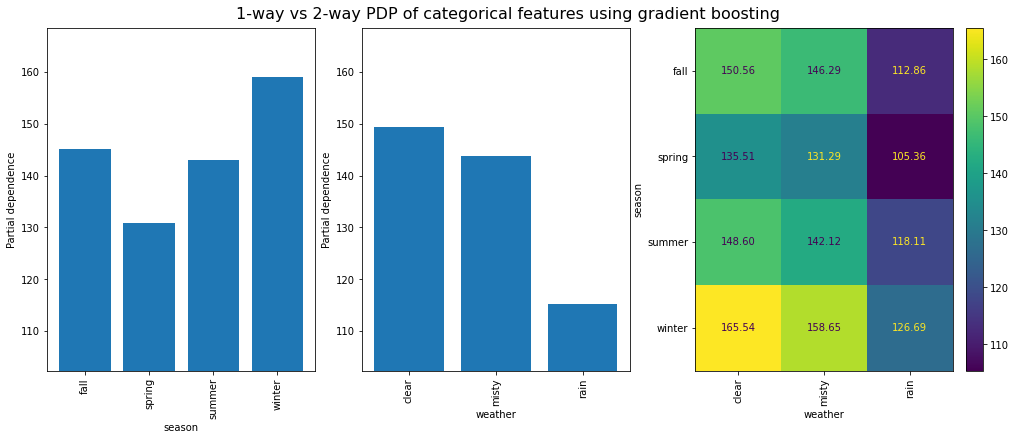

In [31]:
print("Computing partial dependence plots...")
features_info = {
    "features": ["season", "weather", ("season", "weather")],
    "kind": "average",
    "categorical_features": categorical_features,
}
_, ax = plt.subplots(ncols=3, figsize=(14, 6), constrained_layout=True)
tic = time()
display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)

print(f"done in {time() - tic:.3f}s")
_ = display.figure_.suptitle(
    "1-way vs 2-way PDP of categorical features using gradient boosting", fontsize=16
)

Se observa que mayor dependencia positiva ocurre en invierno cuando está despejado, mientras que la mayor dependencia negativa es cuando es primavera y está lloviendo.

## Métodos locales agnósticos al modelo

### Valores de Shapley

Los valores de Shapley son una forma de distribuir las ganancias entre los jugadores de un juego cooperativo basado en las contribuciones individuales al total.

En el caso de ML, podemos pensar en las características de un modelo como los jugadores y las ganancias como a la predicción de un modelo dado menos el promedio de las predicciones de todos los posibles modelos.

## Cómputo

La idea principal es asignar un valor a cada jugador (característica) que represente su **contribución marginal promedio** a las ganancias totales, considerando **todas las posibles coaliciones** (combinaciones de jugadores o características). En otras palabras, ¿cuál es la diferencia en el valor dada la influencia del jugador (característica) considerando los modelos entrenados con todas las posibles combinaciones de características?

Los valores de Shapley se definen como:

$\Large \phi_i(v) = \sum\limits_{S \subseteq N \setminus\lbrace i\rbrace}  \binom{n}{1, |S|, n - |S| - 1}^{-1} (v(S \cup \lbrace i \rbrace) - v(S))$

donde $\phi_i(v)$ es el valor de Shapley de la característica $i$ dada la función de valor $v$, $n$ es el número total de jugadores (características), y la suma se extiende sobre todos los subconjuntos $S$ del conjunto total de jugadores (características), $N$, que excluyen a $i$.

En la práctica, para simular valores que no están presentes en una coalición sin tener que generar un modelo para cada coalición, se puede samplear aleatoriamiente de la distribución de características de la variable dada.

Se puede demostrar que el valor de Shapley es el único método de atribución de valor que satisface las propiedades de Eficiencia, Simetría, Valores Dummy y Aditividad.

- Eficiencia: las contribuciones de las características deben sumar la diferencia entre el valor predicho y la predicción promedio.
- Simetría: la contribución de dos características j y k deben ser la misma si ellos contribuyen de igual manera a las coaliciones.
- Valor Dummy: una característica j que no cambia el valor predicho debe tener un valor de Shapley de cero.
- Additividad: En un juego de contribuciones combinadas, los valores de Shapley deben ser sumados.

Notar que el valor de Shaplay NO es la diferencia entre el valor predicho después de remover una característica de un modelo durante el entrenamiento. Es la diferencia entre el valor predicho y la predicción media considerando todas las posibles coaliciones.

# SHAP (SHapley Additive exPlanations) 

En SHAP el valor de Shapley es representado por un modelo lineal:

$\Large g(z')  =  \phi_0 + \sum\limits_{j=1}^{M} \phi_j z'_j$

donde $g$ es el modelo explicativo, $z' \in \lbrace 0, 1 \rbrace^M$ es un vector de coalición (0 cuando la característica no se usa, 1 cuando sí), $M$ es el tamaño máximo de las coaliciones, y $\phi_j \in \mathbb{R}$ es el valor atribuido a una característica $j$, o el valor de SHAP de la característica $j$.

La predicción del modelo cuando todos las características son usadas corresponde a $g(x')$, donde $x'$ es un vector de 1s.

Para estimar los valores de SHAP values, $K$ coaliciones diferentes son muestreadas ($z'$) y un modelo lineal es ajustado para obtener los valores $\phi_j$. Las predicciones como función de $z'$ son pesadas de acuerdo a un kernel de SHAP que está construido para satisfacer las definiciones de los valores de Shapley:

$\Large \pi_x(z')=\frac{(M-1)}{\binom{M}{|z'|} |z'| (M - |z'|)}$

donde $M$ es el tamaño máximo de las coaliciones y $|z'|$ es el número de características de la coalición $z'$.

Los pesos son aplicados usando la siguiente función de pérdida cuando se ajusta el modelo lineal $g$:

$\Large L(\hat{f}, g, \pi_x) = \sum\limits_{z' \in Z} [ \hat{f}(h_x(z')) - g(z')]^2 \pi_x(z')$

donde $Z$ es el conjunto de entrenamiento.

## Valores de SHAP en el conjunto de datos Iris.

In [33]:
import numpy as np
import pandas as pd
import shap
import xgboost
import seaborn as sn

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

shap.initjs()

Cargaremos el conjunto de datos iris y lo dividiremos en training y testing

In [36]:
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['species'] = iris.target
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


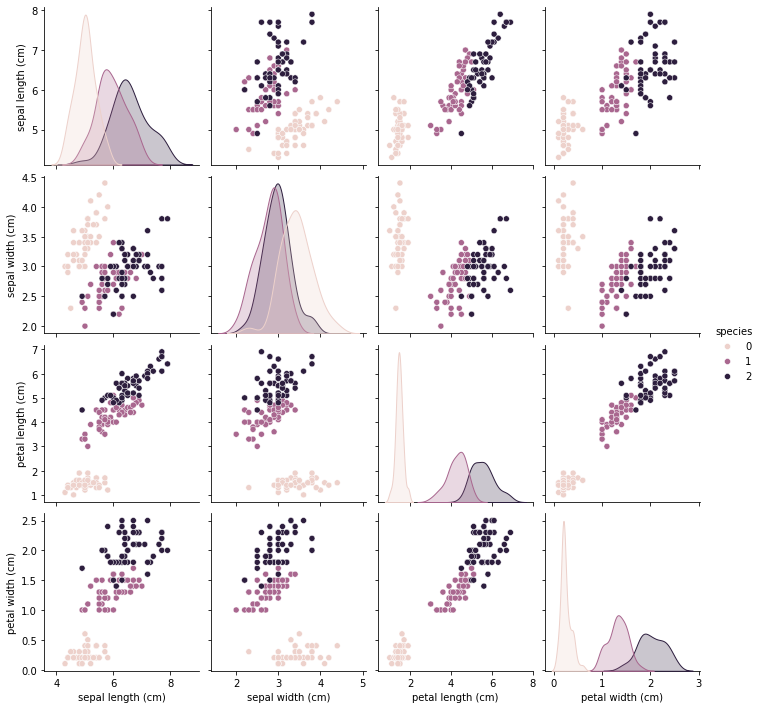

In [38]:
sn.pairplot(df, hue='species')

### Train an XGBoost model

In [39]:
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X_train, label=y_train), 100)

### Initialize SHAP explainer

In [40]:
explainer = shap.Explainer(model)

### Calculate SHAP values for individual samples

In [41]:
# Select a test instance
instance_idx = 5
instance = X_test.iloc[[instance_idx]]
print(instance)
print(y_test[instance_idx])
print(model.predict(xgboost.DMatrix(instance)))

    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
31                5.4               3.4                1.5               0.4
0
[0.18758056]


In [42]:
# Calculate SHAP values
shap_values = explainer(instance)

In [43]:
# Plot SHAP values
shap.plots.force(shap_values)

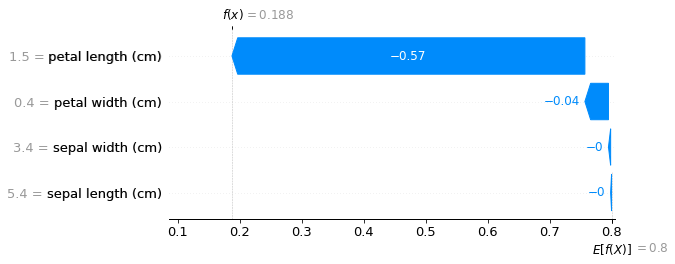

In [44]:
shap.plots.waterfall(shap_values[0])#, max_display=14)

En este caso, petal length explica en gran parte la clasificación del objeto.

### Mean SHAP value for the whole distribution


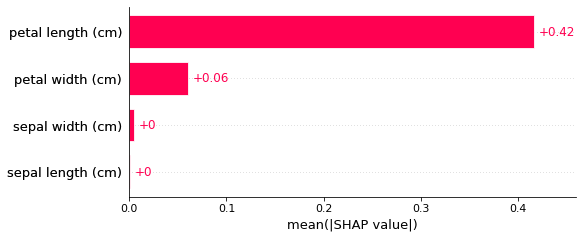

In [45]:
shap_values_test = explainer(X_test)

# Plot SHAP values
shap.plots.bar(shap_values_test.abs.mean(0))

Vemos que petal length tiene el efecto más grande entre todas las características, seguido de petal width. las otras variables prácticamente no contribuyen.

### Distribution of values for the whole distribution

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


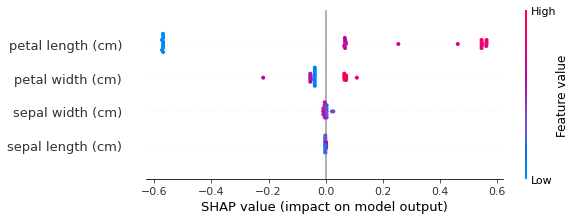

In [47]:
shap.plots.beeswarm(shap_values_test)

Se observa el tamaño y el signo del efecto para todas las muestras. Se observa que en algunos casos petal width parece ser tan buen discriminador como petal length.

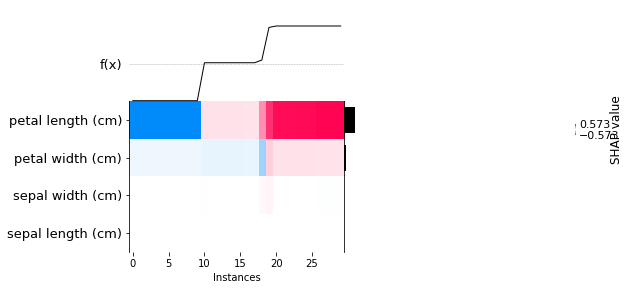

In [123]:
shap.plots.heatmap(shap_values_test)

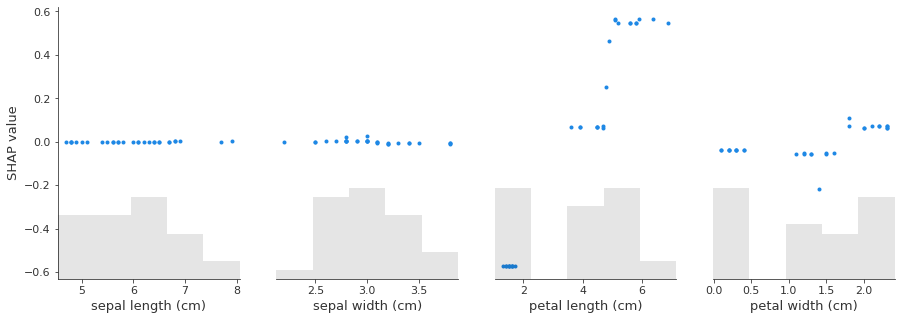

In [48]:
shap.plots.scatter(shap_values_test)

In [49]:
shap_values_test

.values =
array([[ 7.52410851e-04,  2.05395487e-03,  6.45547062e-02,
        -5.27123697e-02],
       [-1.47561182e-03, -3.48902261e-03, -5.68979561e-01,
        -3.80130634e-02],
       [ 1.33121014e-03,  3.07423156e-03,  5.45917094e-01,
         7.08222240e-02],
       [-1.36104866e-03,  2.00486998e-03,  6.78977296e-02,
        -5.38928658e-02],
       [ 1.49948150e-03,  2.18978897e-02,  2.54141718e-01,
        -2.18873486e-01],
       [-1.47561182e-03, -3.48902261e-03, -5.68979561e-01,
        -3.80130634e-02],
       [-1.36104866e-03,  2.00486998e-03,  6.78977296e-02,
        -5.38928658e-02],
       [ 1.44577317e-03, -7.25097349e-03,  5.61894178e-01,
         6.50556833e-02],
       [ 7.13143032e-04, -2.86675728e-04,  6.69227690e-02,
        -5.27005568e-02],
       [-1.36104866e-03,  2.00486998e-03,  6.78977296e-02,
        -5.38928658e-02],
       [ 1.03590032e-03, -8.39896407e-03,  5.62808752e-01,
         6.56990036e-02],
       [-1.36104866e-03,  1.52432441e-03, -5.73279083e-

## Test the SHAP values with the QSO and stars dataset

In [50]:
stars = pd.read_csv("data/SDSS_stars.csv")
stars.head()

,u_mag,g_mag,r_mag,i_mag,z_mag,ra,dec
0,20.533161,17.968031,16.827314,16.373095,16.091063,190.001261,21.910620
1,18.894476,17.674576,17.208895,17.033516,16.972940,190.002330,21.874641
2,18.290901,17.022612,16.625498,16.431305,16.399673,190.012240,21.702999
3,19.784182,17.820679,17.003235,16.721306,16.541569,190.012912,23.667913
4,18.874607,17.638632,17.120625,16.907972,16.849592,190.012951,24.797507


In [51]:
QSOs = pd.read_csv("data/SDSS_QSO.dat", sep = "\s+", index_col = "SDSS")
QSOs.head()

,z,u_mag,sig_u_mag,g_mag,sig_g_mag,r_mag,sig_r_mag,i_mag,sig_i_mag,z_mag,sig_z_mag,FIRST,ROSAT,Mp
SDSS,,,,,,,,,,,,,,
000006.53+003055.2,1.8227,20.389,0.066,20.468,0.034,20.332,0.037,20.099,0.041,20.053,0.121,0.0,-9.0,-25.100
000008.13+001634.6,1.8365,20.233,0.054,20.200,0.024,19.945,0.032,19.491,0.032,19.191,0.068,0.0,-9.0,-25.738
000009.26+151754.5,1.1986,19.921,0.042,19.811,0.036,19.386,0.017,19.165,0.023,19.323,0.069,-1.0,-9.0,-25.085
000009.38+135618.4,2.2400,19.218,0.026,18.893,0.022,18.445,0.018,18.331,0.024,18.110,0.033,-1.0,-9.0,-27.419
000009.42-102751.9,1.8442,19.249,0.036,19.029,0.027,18.980,0.021,18.791,0.018,18.751,0.047,0.0,-9.0,-26.459


In [52]:
stars["cat"] = "star"
stars["ug"] = stars.u_mag - stars.g_mag
stars["gr"] = stars.g_mag - stars.r_mag
stars["ri"] = stars.r_mag - stars.i_mag
stars["iz"] = stars.i_mag - stars.z_mag
QSOs["cat"] = "QSO"
QSOs["ug"] = QSOs.u_mag - QSOs.g_mag
QSOs["gr"] = QSOs.g_mag - QSOs.r_mag
QSOs["ri"] = QSOs.r_mag - QSOs.i_mag
QSOs["iz"] = QSOs.i_mag - QSOs.z_mag

In [53]:
sel_cols = ["ug", "gr", "ri", "iz", "cat"]
data = pd.concat([stars[sel_cols], QSOs[sel_cols].sample(5000, random_state=1)])
#data = pd.concat([stars[sel_cols], QSOs[sel_cols]])
data["cat"] = data["cat"].astype("category")
data.sample(10)

,ug,gr,ri,iz,cat
4450,2.017410,0.789711,0.296707,0.085357,star
122158.68+365039.1,0.384000,0.004000,0.135000,0.016000,QSO
122753.38+454312.2,0.014000,-0.004000,0.189000,0.139000,QSO
111028.08+021134.0,0.167000,0.167000,0.033000,-0.126000,QSO
1583,1.851481,0.823030,0.297287,0.169750,star
011539.45-001359.9,0.547000,0.010000,0.095000,0.099000,QSO
141938.37+125227.0,0.277000,0.336000,0.166000,0.003000,QSO
123821.43+131245.8,0.008000,0.321000,0.023000,0.847000,QSO
100653.21+383016.2,0.032000,0.212000,-0.083000,-0.138000,QSO
127,1.088217,0.365481,0.138816,0.020807,star


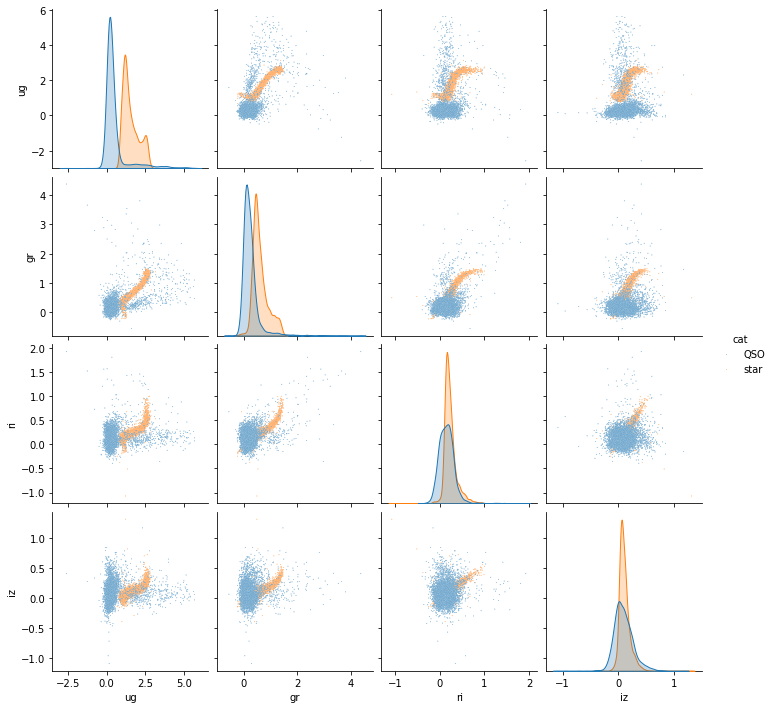

In [54]:
sn.pairplot(data, hue='cat', plot_kws={"s": 3, 'marker': '.'})

In [55]:
X_train, X_test, y_train, y_test = train_test_split(data[["ug", "gr", "ri", "iz"]], data.cat, test_size=.4, random_state=42)

In [56]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(data.cat)
print(le.classes_)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

['QSO' 'star']


In [57]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [58]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(criterion='entropy', n_estimators=1000, oob_score=True, n_jobs=4)#, class_weight='balanced')
y_pred = rfc.fit(X_train, y_train).predict(X_test)
print("Out-of-bag score:", rfc.oob_score_)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print("f1-score:", metrics.f1_score(y_test, y_pred, pos_label=1))
print("Feature importance:", dict(zip(list(X_train), rfc.feature_importances_)))

Out-of-bag score: 0.9915
Accuracy: 0.994
f1-score: 0.9941916747337852
Feature importance: {'ug': 0.6601077708084173, 'gr': 0.2144333353299219, 'ri': 0.0742207370060748, 'iz': 0.05123815685558596}


Text(0, 0.5, 'Feature importance')

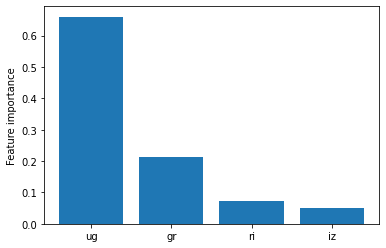

In [59]:
fig, ax = plt.subplots()
ax.bar(list(X_train), rfc.feature_importances_)
ax.set_ylabel("Feature importance")

### Initialize SHAP explainer object

In [60]:
explainer = shap.Explainer(rfc)

In [61]:
instance = X_test.loc[[0]]
shap_values = explainer.shap_values(instance)

In [62]:
instance.values

array([[2.56513 , 1.140717, 0.454219, 0.282032]])

In [63]:
rfc.predict_proba(instance.values)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


array([[0.012, 0.988]])

In [64]:
explainer.expected_value

array([0.50957567, 0.49042433])

In [65]:
shap_values

[array([[-0.30422348, -0.15338032, -0.04843184,  0.00845997]]),
 array([[ 0.30422348,  0.15338032,  0.04843184, -0.00845997]])]

In [66]:
shap.force_plot(explainer.expected_value[0], shap_values[0], instance)

In [67]:
shap.force_plot(explainer.expected_value[1], shap_values[1], instance)

### Get the values for the full sample

In [68]:
shap_values_test = explainer(X_test) #.shap_values

In [69]:
shap_values_test.values.shape

(4000, 4, 2)

### Bar summary plot

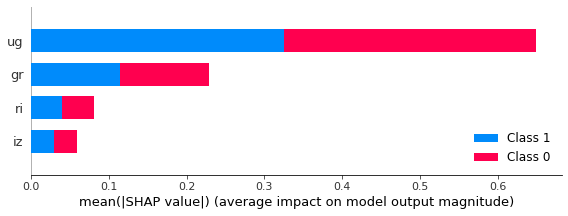

In [70]:
shap.summary_plot([shap_values_test.values[:, :, 0], shap_values_test.values[:, :, 1]], X_test)

### Beeswarm plot

Class 0

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


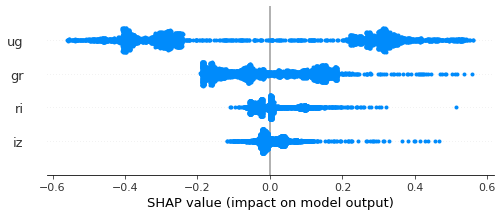

In [71]:
shap.plots.beeswarm(shap.Explanation(shap_values_test.values[:, :, 0], base_values=shap_values_test.base_values, feature_names=X_test.columns))

Class 1

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


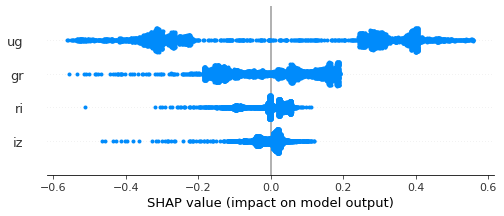

In [72]:
shap.plots.beeswarm(shap.Explanation(shap_values_test.values[:, :, 1], base_values=shap_values_test.base_values, feature_names=X_test.columns))

### Compare feature importance and SHAP values

In [73]:
shap_values_test[:, :, 0].abs.mean(0)

.values =
array([0.3244839 , 0.11466603, 0.04053077, 0.02978122])

.base_values =
0.5095756666666669

.data =
array([1.03733059, 0.43243674, 0.20860436, 0.12745577])

Text(0, 0.5, 'SHAP values')

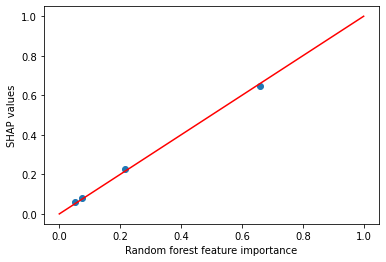

In [74]:
fig, ax = plt.subplots()
ax.scatter(rfc.feature_importances_, shap_values_test[:, :, 0].abs.mean(0).values + shap_values_test[:, :, 1].abs.mean(0).values)
ax.plot([0, 1], [0, 1], c='r')
ax.set_xlabel("Random forest feature importance")
ax.set_ylabel("SHAP values")

In [75]:
rfc.feature_importances_.sum()

1.0

In [76]:
np.sum(shap_values_test[:, :, 0].abs.mean(0).values + shap_values_test[:, :, 1].abs.mean(0).values)

1.0189238459401604

# MNIST

In [233]:
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import colormaps as cmaps

In [234]:
import tensorflow as tf
import shap
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Load MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Reshape the data
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Build the model
model = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=5, validation_split=0.2)

Epoch 1/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2928 - accuracy: 0.9169 - val_loss: 0.1652 - val_accuracy: 0.9541
Epoch 2/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.1348 - accuracy: 0.9605 - val_loss: 0.1329 - val_accuracy: 0.9614
Epoch 3/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0923 - accuracy: 0.9730 - val_loss: 0.1098 - val_accuracy: 0.9672
Epoch 4/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0695 - accuracy: 0.9794 - val_loss: 0.1000 - val_accuracy: 0.9703
Epoch 5/5
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0531 - accuracy: 0.9836 - val_loss: 0.0966 - val_accuracy: 0.9716


In [235]:
predictions = model.predict(x_test).argmax(axis=1)

In [236]:
predictions

array([7, 2, 1, ..., 4, 5, 6])

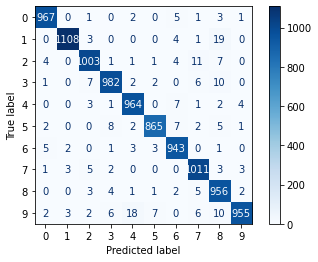

In [237]:
# Show confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, predictions, cmap=cmaps["Blues"])

## Deep Shap Explainer

This method needs a random sample in the training set

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


0


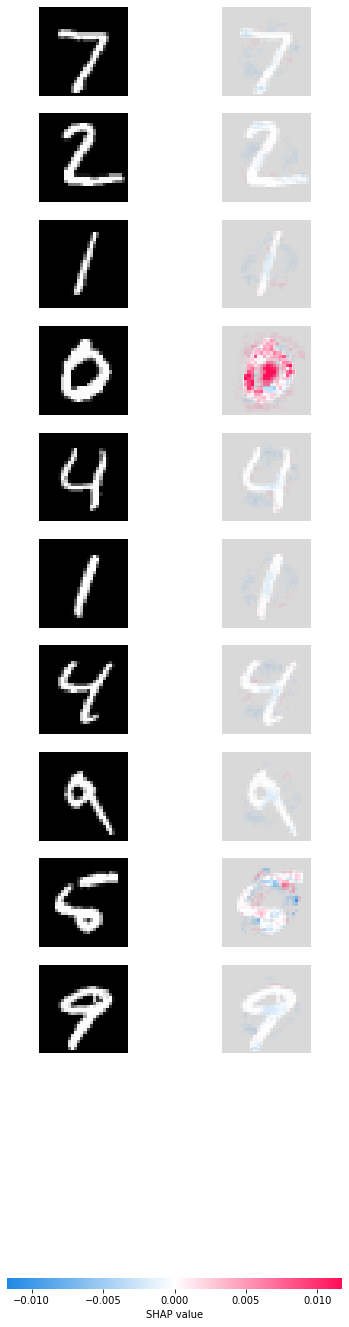

1


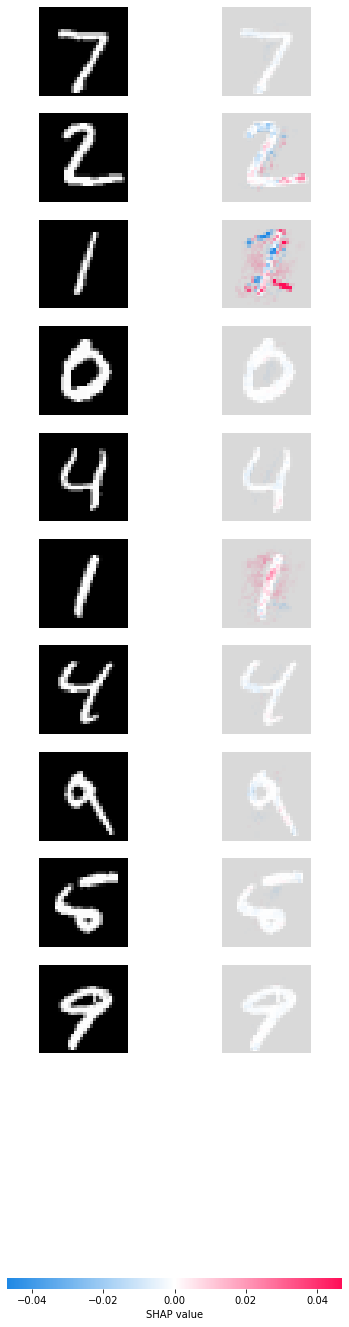

2


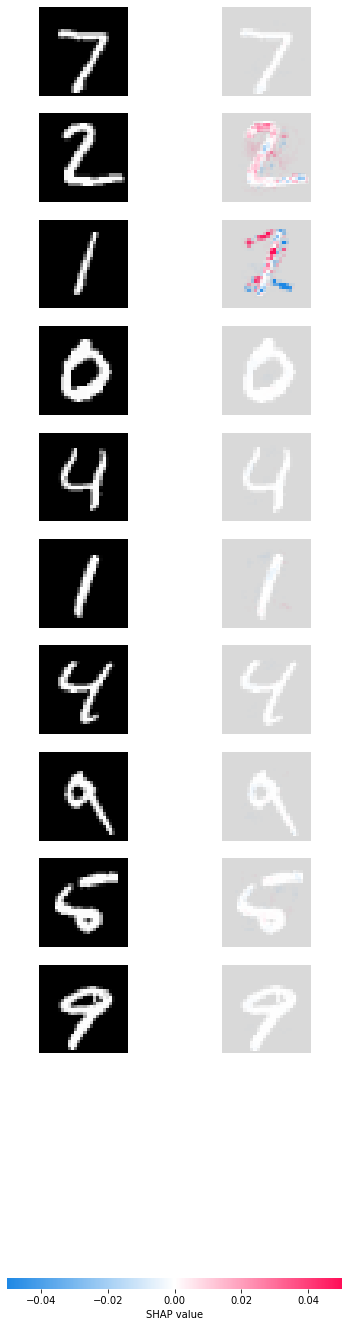

3


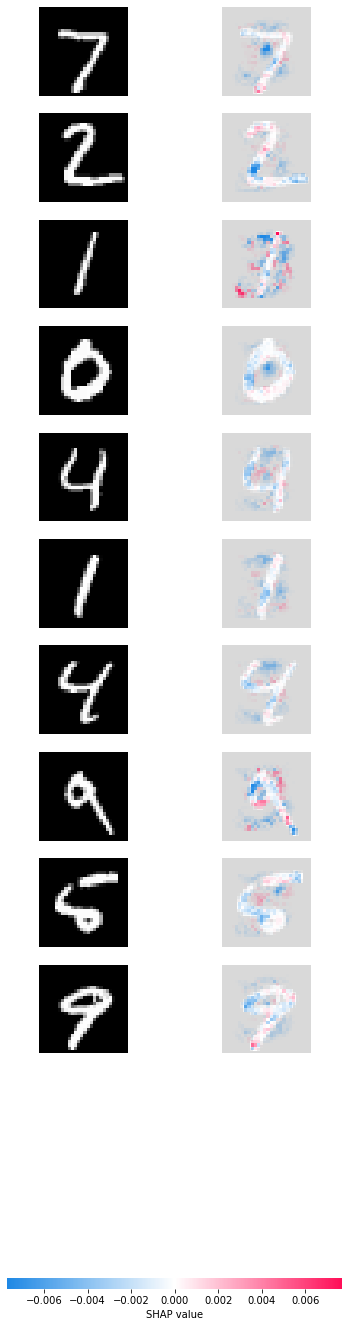

4


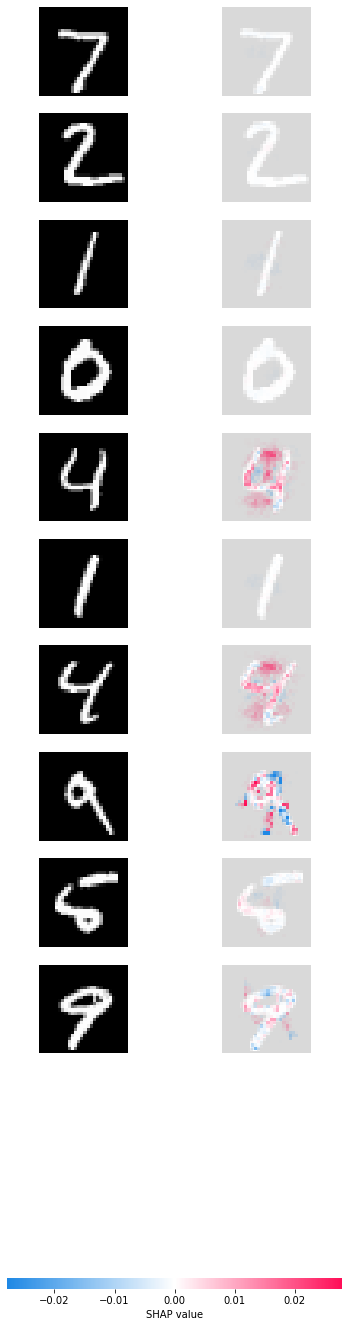

5


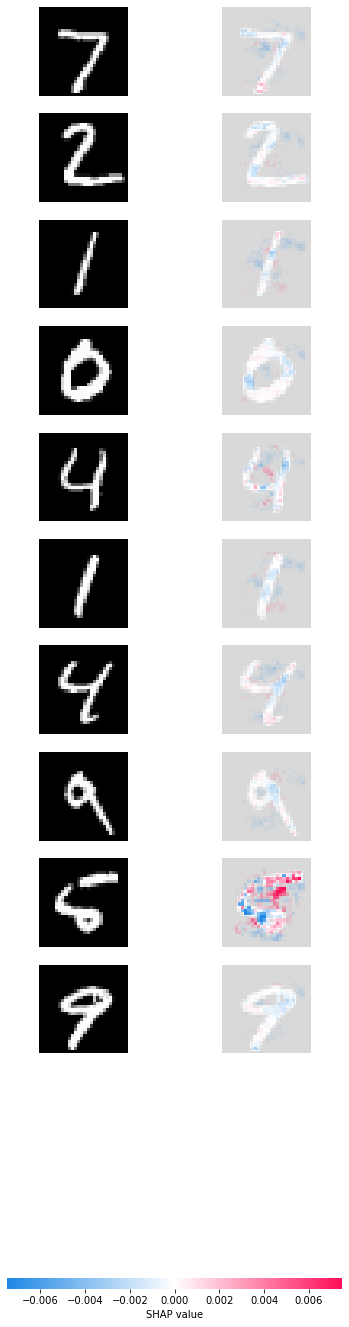

6


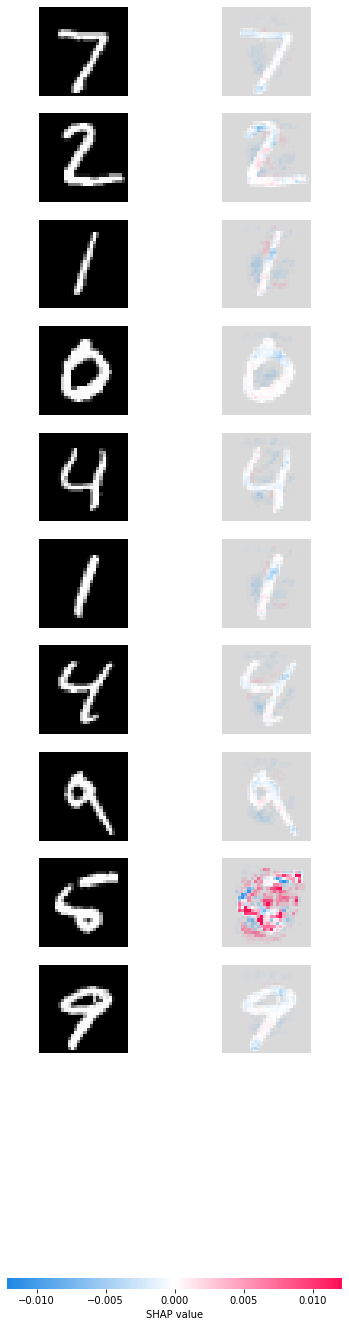

7


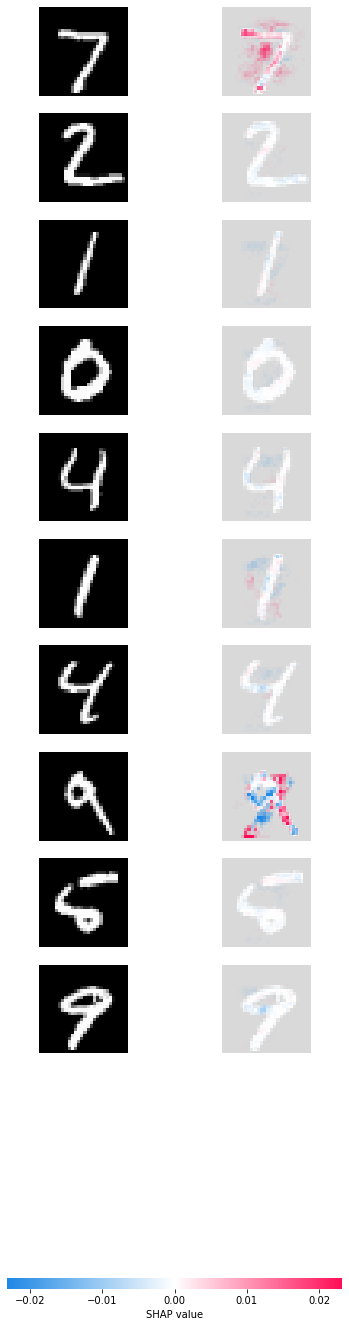

8


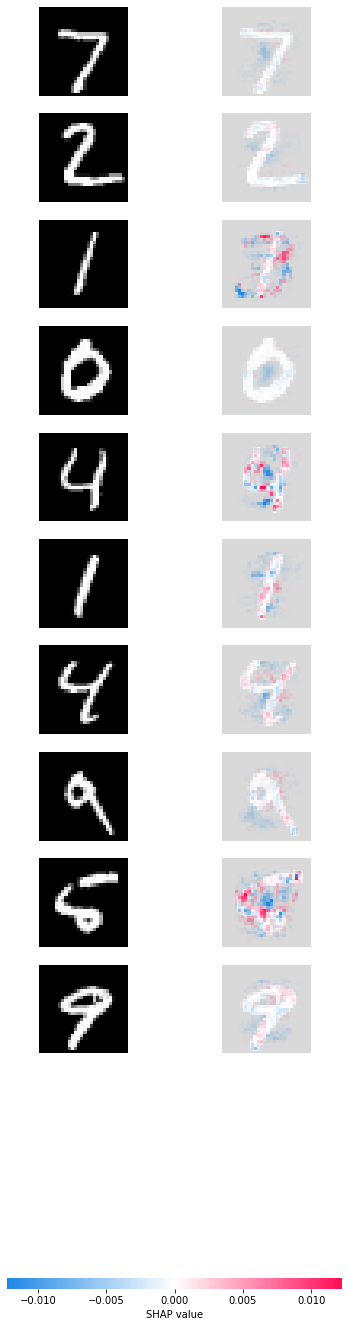

9


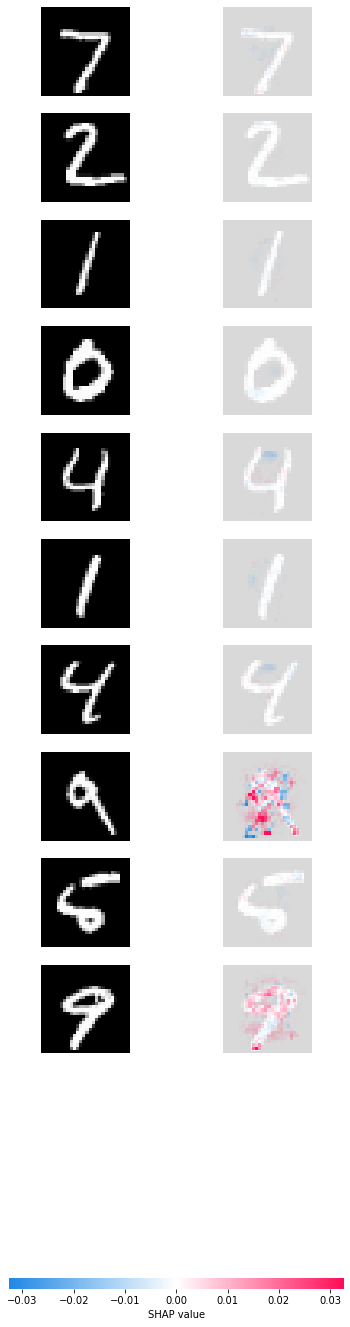

In [242]:
# Select a subset of the test data to explain
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]
test_samples = x_test[:10]

# Create a SHAP explainer
explainer = shap.DeepExplainer(model, background)

# Compute SHAP values for the test samples
shap_values = explainer.shap_values(test_samples)

for n in range(10):
    print(n)
    # Plot the SHAP values for a specific class (e.g., digit 0)
    shap.image_plot(shap_values[n], test_samples)
